In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score as sil_, calinski_harabasz_score as calinski_
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
import re
from datetime import datetime, timezone
from sklearn.preprocessing import OneHotEncoder
import ipaddress
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from collections import Counter
import plotly.express as px
import matplotlib.dates as mdates
import folium
import pytz
from timezonefinder import TimezoneFinder
import pickle

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data/omnipot.csv')

In [3]:
df.drop_duplicates(inplace=True)

In [4]:
df.isna().sum()

src_port                0
dst_port                0
timestamp               0
src_as               2657
src_city                5
src_country             0
src_countryCode        42
src_geo_str             0
src_ip                  0
src_proxy               0
src_regionName        171
dst_as                  0
dst_city                0
dst_country             0
dst_countryCode         0
dst_geo_str             0
dst_ip                  0
dst_proxy               0
dst_regionName          0
protocol                0
payload_4kb_hex    209362
dtype: int64

In [5]:
df.dropna(subset="payload_4kb_hex", inplace=True)

In [6]:
df.shape

(468591, 21)

In [7]:
# ef bf bd is a very likely sign of the presence of so a corrupted payload �
df[df['payload_4kb_hex'].str.contains("efbfbd", na=False)].shape

(296419, 21)

In [8]:
import binascii

def is_probably_corrupted(hex_str):
    try:
        raw_bytes = bytes.fromhex(hex_str)
        decoded = raw_bytes.decode('utf-8')
        return '�' in decoded  # Check for U+FFFD
    except:
        return False
    
df_suspect = df[df['payload_4kb_hex'].str.contains("efbfbd", na=False)].copy()
df_suspect['is_probably_corrupted'] = df_suspect['payload_4kb_hex'].apply(is_probably_corrupted)


In [9]:
df_suspect['is_probably_corrupted'].value_counts()

is_probably_corrupted
True    296419
Name: count, dtype: int64

In [10]:
df.drop(index=df[df['payload_4kb_hex'].str.contains("efbfbd", na=False)].index, inplace=True)

In [11]:
df

,src_port,dst_port,timestamp,src_as,src_city,src_country,src_countryCode,src_geo_str,src_ip,src_proxy,...,dst_as,dst_city,dst_country,dst_countryCode,dst_geo_str,dst_ip,dst_proxy,dst_regionName,protocol,payload_4kb_hex
2,13652,22,1743924731683,AS6939 Hurricane Electric LLC,Alameda,United States,US,-122.262|37.7688,184.105.247.252,False,...,"AS20473 The Constant Company, LLC",Querétaro City,Mexico,MX,-100.2899|20.5737,216.238.89.44,True,Querétaro,ssh,474554202f20485454502f312e310d0a486f73743a2032...
5,60497,22,1743924736244,AS6939 Hurricane Electric LLC,Fremont,United States,US,-121.931|37.49,64.62.197.112,False,...,"AS20473 The Constant Company, LLC",Atlanta,United States,US,-84.4455|33.7838,104.238.179.29,False,Georgia,ssh,474554202f20485454502f312e310d0a486f73743a2031...
12,38560,80,1738746131049,"AS14061 DigitalOcean, LLC",Singapore,Singapore,SG,103.695|1.32123,128.199.179.71,False,...,"AS20473 The Constant Company, LLC",Singapore,Singapore,SG,103.695|1.32123,45.32.124.12,False,South West,http,474554202f68656c6c6f20485454502f312e310d0a486f...
18,48162,443,1738746141314,AS63949 Akamai Connected Cloud,Fremont,United States,US,-122.0004|37.5625,45.33.109.8,False,...,"AS20473 The Constant Company, LLC",Querétaro City,Mexico,MX,-100.2899|20.5737,216.238.86.69,True,Querétaro,https,474554202f20485454502f312e310d0a486f73743a2032...
21,42914,80,1738746143899,"AS14061 DigitalOcean, LLC",Singapore,Singapore,SG,103.695|1.32123,128.199.170.18,False,...,"AS20473 The Constant Company, LLC",Singapore,Singapore,SG,103.695|1.32123,45.32.124.12,False,South West,http,474554202f68656c6c6f20485454502f312e310d0a486f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965074,42792,22,1743465456661,AS12400 Partner Communications Ltd.,Jerusalem,Israel,IL,35.2186|31.7674,84.95.208.63,False,...,"AS20473 The Constant Company, LLC",Amsterdam,The Netherlands,NL,4.6563|52.3891,95.179.186.46,False,North Holland,ssh,5353482d322e302d476f0d0a
965075,42786,22,1743465456525,AS12400 Partner Communications Ltd.,Jerusalem,Israel,IL,35.2186|31.7674,84.95.208.63,False,...,"AS20473 The Constant Company, LLC",Amsterdam,The Netherlands,NL,4.6563|52.3891,95.179.186.46,False,North Holland,ssh,5353482d322e302d476f0d0a
965076,42776,22,1743465456396,AS12400 Partner Communications Ltd.,Jerusalem,Israel,IL,35.2186|31.7674,84.95.208.63,False,...,"AS20473 The Constant Company, LLC",Amsterdam,The Netherlands,NL,4.6563|52.3891,95.179.186.46,False,North Holland,ssh,5353482d322e302d476f0d0a
965077,53924,443,1743465477010,"AS16509 Amazon.com, Inc.",Dublin,United States,US,-83.1141|40.0992,3.136.87.118,False,...,"AS20473 The Constant Company, LLC",Whitechapel,United Kingdom,GB,-0.0638|51.5128,95.179.201.146,False,England,https,5353482d322e302d476f0d0a


In [12]:
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

In [13]:
# filling payload nan with "" the ndrop nan that are not in the payload column as empty payloads are valid
df.fillna({"payload_4kb_hex":""}, inplace=True)
df.dropna(inplace=True)

In [14]:
def get_ip_encoding(ipv4):
    oct1, oct2, oct3, oct4 = ipv4.split('.')
    return  int(oct1), int(oct2), int(oct3), int(oct4)

df[['src_oct1', 'src_oct2', 'src_oct3', 'src_oct4']] = df["src_ip"].apply(get_ip_encoding).apply(pd.Series)
df[['dst_oct1', 'dst_oct2', 'dst_oct3', 'dst_oct4']] = df["dst_ip"].apply(get_ip_encoding).apply(pd.Series)

In [15]:
df["src_geo_str"] = df["src_geo_str"].str.split("|").apply(lambda lst: [float(x) for x in lst])
df["dst_geo_str"] = df["dst_geo_str"].str.split("|").apply(lambda lst: [float(x) for x in lst])

In [16]:
from scipy.stats import entropy

def get_payload_features(payload):
    default = {'length': 0, 'unique_bytes': 0, 'entropy': 0.0,
               'mean_byte': 0.0, 'std_byte': 0.0}
    if not isinstance(payload, str) or len(payload) == 0:
        return default
    try:
        data = bytes.fromhex(payload)
    except ValueError:
        return default
    length = len(data)
    if length == 0:
        return default
    arr = np.frombuffer(data, dtype=np.uint8)
    counts = np.bincount(arr, minlength=256)
    probs = counts / length

    probs = probs[probs > 0]
    ent = entropy(probs, base=2)
    mean = float(arr.mean())
    std = float(arr.std())
    return {
        'length': length,
        'unique_bytes': int(np.count_nonzero(counts)),
        'entropy': float(ent),
        'mean_byte': mean,
        'std_byte': std
    }

payload_feats = ['pl_length', 'pl_unique_bytes', 'pl_entropy', 'pl_mean_byte', 'pl_std_byte']
df[payload_feats] = df["payload_4kb_hex"].apply(get_payload_features).apply(pd.Series)

In [17]:
def decode_payload(hex_str: str, protocol: str) -> str:
    if not hex_str or not isinstance(hex_str, str):
        return ""
    
    try:
        raw_bytes = bytes.fromhex(hex_str)
        if not raw_bytes:
            return ""

        # --- SSH ---
        if protocol == 'ssh':
            if raw_bytes.startswith(b'SSH-'):
                banner = raw_bytes.decode('utf-8', errors='ignore').split('\n')[0]
                return banner.strip()
            if raw_bytes.startswith((b'GET ', b'POST ', b'HEAD ', b'PUT ')):
                return "HTTP_OVER_SSH: " + raw_bytes.decode('utf-8', errors='ignore').split('\r\n')[0]
            try:
                text = raw_bytes.decode('utf-8', errors='ignore')
                if any(cmd in text.lower() for cmd in ['wget', 'curl', 'chmod', 'sh -c']):
                    return "SSH_CMD: " + ' '.join(text.split())[:200]
            except:
                pass
            return f"SSH_BINARY_{len(raw_bytes)}B"

        # --- HTTP/HTTPS ---
        elif protocol in ['http', 'https']:
            if raw_bytes.startswith(b'SSH-'):
                return "SSH_OVER_HTTP"
            if raw_bytes.startswith((b'GET ', b'POST ', b'HEAD ', b'PUT ')):
                return "HTTP: " + raw_bytes.decode('utf-8', errors='ignore').split('\r\n')[0]
            if len(raw_bytes) > 0 and raw_bytes[0] == 0x16:
                return "SSL_HANDSHAKE"
            try:
                text = raw_bytes.decode('utf-8', errors='ignore')
                if text.strip():
                    return f"HTTP_TEXT: {text[:200]}"
            except:
                pass
            return f"HTTP_BINARY_{len(raw_bytes)}B"

        # --- SMB ---
        elif protocol == 'smb':
            if len(raw_bytes) > 8:
                smb_commands = {
                    0x00: "SMB_NEGOTIATE",
                    0x73: "SMB_NEGOTIATE",
                    0x75: "SMB_TREE_CONNECT",
                    0x1d: "SMB_SESSION_SETUP",
                    0x25: "SMB_CREATE",
                    0x2e: "SMB_IOCTL",
                    0x32: "SMB_READ",
                    0x0b: "SMB_TREE_DISCONNECT"
                }
                cmd = smb_commands.get(raw_bytes[4], f"SMB_UNKNOWN_{raw_bytes[4]}")
                return cmd if cmd != "SMB_NEGOTIATE" or raw_bytes[4:8] == b'\xffSMB' else "SMB_INVALID"
            return "SMB_EMPTY"

        # --- FTP ---
        elif protocol == 'ftp' or b'USER ' in raw_bytes or b'PASS ' in raw_bytes:
            try:
                ftp_text = raw_bytes.decode('utf-8', errors='ignore')
                return f"FTP: {ftp_text.strip()[:100]}"
            except:
                return "FTP_BINARY"

        # --- SMTP ---
        elif protocol == 'smtp' or b'MAIL FROM' in raw_bytes or b'HELO' in raw_bytes:
            try:
                smtp_text = raw_bytes.decode('utf-8', errors='ignore')
                return f"SMTP: {smtp_text.strip()[:100]}"
            except:
                return "SMTP_BINARY"

        # --- Telnet ---
        elif protocol == 'telnet':
            try:
                telnet_text = raw_bytes.decode('utf-8', errors='ignore')
                return f"TELNET: {telnet_text.strip()[:100]}"
            except:
                return "TELNET_BINARY"

        # --- SSL/TLS (generic fallback) ---
        elif protocol == 'ssl' or (len(raw_bytes) > 0 and raw_bytes[0] == 0x16):
            return "SSL_HANDSHAKE"

        # --- Generic TCP fallback ---
        elif protocol == 'tcp':
            printable_ratio = sum(32 <= b <= 126 for b in raw_bytes) / len(raw_bytes)
            if printable_ratio > 0.8:
                return f"TCP_TEXT: {raw_bytes.decode('utf-8', errors='ignore')[:200]}"
            else:
                return f"TCP_BINARY_{len(raw_bytes)}B"

        # --- Default: Other / Unknown ---
        else:
            try:
                text = raw_bytes.decode('utf-8', errors='ignore')
                if text.strip():
                    return f"{protocol}_TEXT: {text[:200]}"
            except:
                pass
            return f"{protocol}_BINARY_{len(raw_bytes)}B"

    except Exception as e:
        return f"DECODE_ERROR_{str(e)}"

# Reapply decoding
df['payload_decoded'] = df.apply(
    lambda row: decode_payload(row['payload_4kb_hex'], row['protocol']), 
    axis=1
)

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

def get_code_embeddings(payloads, model_name='microsoft/codebert-base', batch_size=16):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    embeddings = []
    for i in tqdm(range(0, len(payloads), batch_size), desc="Embedding Batches"):
        batch = payloads[i:i + batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors='pt')
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            cls_vectors = outputs.last_hidden_state[:, 0, :]
            embeddings.extend(cls_vectors.cpu().numpy())

    return embeddings

# Usage
valid_indices = df['payload_decoded'].astype(str).str.strip().ne('')
valid_payloads = df.loc[valid_indices, 'payload_decoded'].astype(str).tolist()
vectors = get_code_embeddings(valid_payloads[:30000])


Embedding Batches:   0%|          | 2/1875 [00:01<20:39,  1.51it/s]


KeyboardInterrupt: 

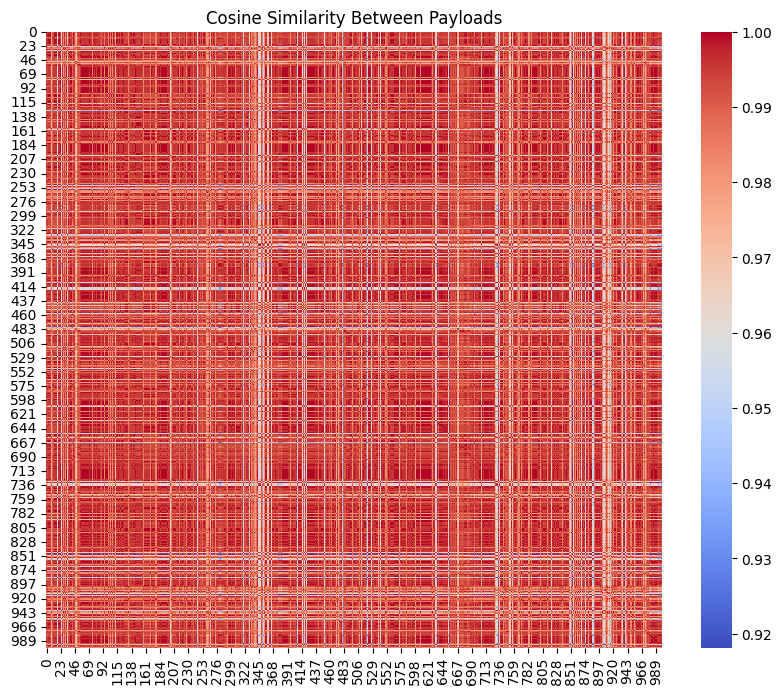

In [21]:
cosine_sim_matrix = cosine_similarity(vectors[:1000])
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix, cmap="coolwarm", square=True)
plt.title("Cosine Similarity Between Payloads")
plt.show()

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


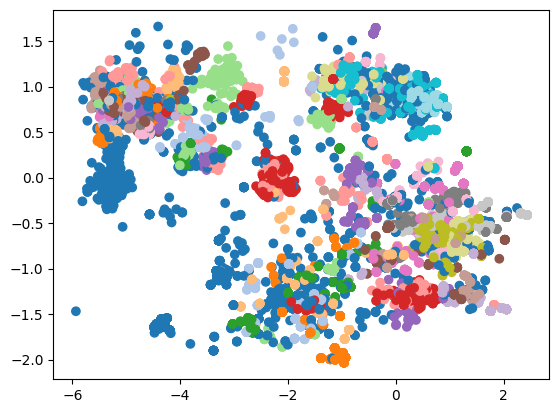

In [28]:
from hdbscan import HDBSCAN
clusterer = HDBSCAN().fit(vectors)
red = df.head(30000).copy()
red['payload_cluster'] = clusterer.labels_

from sklearn.decomposition import PCA
reduced = PCA(n_components=2).fit_transform(vectors)
plt.scatter(reduced[:,0], reduced[:,1], c=red['payload_cluster'], cmap='tab20')
